<a href="https://colab.research.google.com/github/wfreinhart/sdmm-regression/blob/main/notebooks/figure7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# make chart from precomputed data file

## load json

In [ ]:
import numpy as np
import json

all_metrics = {'Seq': {}}
for file_key in ['metrics-sequence-vector.json', 'metrics-dnn.json']:
    with open(file_key, 'r') as fid:
        this_metrics = json.load(fid)
    for k, v in this_metrics.items():
        all_metrics['Seq'][k] = v
with open('metrics-kmers.json', 'r') as fid:
    token_metrics = json.load(fid)
for L, this_metrics in token_metrics.items():
    all_metrics[L] = this_metrics

## read best results

In [ ]:
metric_key = 'rmse'
best_metrics_key = {}
for short_name in all_metrics['Seq'].keys():
    this_metrics = {}
    for key in all_metrics.keys():
        if short_name in all_metrics[key]:
            this_metrics[key] = np.mean([it[metric_key] for it in all_metrics[key][short_name]['test']])
    best_val = np.min(list(this_metrics.values()))
    best_key = [k for k, v in this_metrics.items() if v == best_val][0]
    best_metrics_key[short_name] = best_key

best_metrics = {}
for short_name in all_metrics['Seq'].keys():
    best_metrics[short_name] = all_metrics[best_metrics_key[short_name]][short_name]

In [ ]:
for key in ['RNN', 'MLP-12', 'CNN', 'MLPRegressor', 'Ridge']:
    vals = [it['rmse'] for it in best_metrics[key]['test']]
    print(key, np.mean(vals), np.std(vals))

RNN 1.407435983005784 0.09071761491331667
MLP-12 1.7219231569660685 0.1577552616169461
CNN 1.7468464094376188 0.1305497250261983
MLPRegressor 1.9832761359361684 0.053380249731706964
Ridge 2.478417512543627 0.1508916435703607


## draw charts

In [ ]:
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.font_manager as font_manager
sc = 1.5
matplotlib.rcParams['font.family'] = 'Open Sans'  # the font name
matplotlib.rcParams['font.size'] = 9*sc                   # the font size
font_manager._rebuild()  # this is a hack to fix something in Google Colab

In [ ]:
def create_bar_chart(metrics, metric_key, labels=None):
    # rearrange the data to easily compose the chart
    chart_labels = [k for k, v in metrics.items()]
    chart_data = {'train': [], 'test': []}
    for short_name, these_scores in metrics.items():
        this_dict = {key: [it[metric_key] for it in these_scores[key]] for key in ['train', 'test']}
        for key in ['train', 'test']:
            chart_data[key].append(this_dict[key])

    keys = metrics.keys()

    fig, ax = plt.subplots(figsize=(3.54*sc, 3.54*sc))
    for i, s in enumerate(['train', 'test']):
        if s == 'train':
            mf = 'none'
            h = '//'
            a = 1.0
        else:
            mf = 'tab:blue'
            h = ''
            a = 0.8
        mu = np.mean(chart_data[s], axis=1)
        sigma = np.std(chart_data[s], axis=1)
        ax.bar(np.arange(len(keys))+0.2*(2*i-1), mu, yerr=sigma, label=s, 
            facecolor=mf, alpha=a, hatch=h, 
            width=0.40, color='tab:blue', edgecolor='tab:blue', linewidth=1.5, capsize=4)
        
        if labels is not None and s == 'test':
            for j, k in enumerate(keys):
                best_label = labels[k]
                if best_label != 'Seq':
                    best_label = f"$k={best_label}$"
                if '10' in best_label:
                    offs = 0.10
                else:
                    offs = 0
                ax.text(j+offs, mu[j]+sigma[j]+0.10, best_label, ha='center')
                # print(j, mu[j]+sigma[j]+0.05, best_label)

    ax.set_xticks(np.arange(len(keys)))
    short_keys = [key.split('.')[-1].split("'")[0].replace("Regressor", "").replace("Regression", "")  for key in keys]
    j = np.argwhere([k == 'MLP' for k in short_keys])[0]
    short_keys[int(j)] = 'MLP-1'
    ax.set_xticklabels(short_keys, rotation=45, ha='right')
    ax.legend()
    if metric_key == 'rmse':
        ax.set_ylim(0, 5)
        ax.set_ylabel('RMSE')
    elif metric_key == 'rsq':
        ax.set_ylim(0, 1.01)
        ax.set_ylabel('$R^2$')
    fig.tight_layout()

    return fig

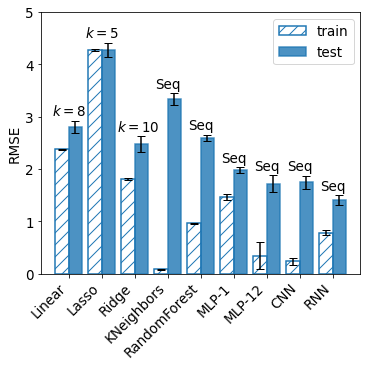

In [ ]:
fig = create_bar_chart(best_metrics, 'rmse', labels=best_metrics_key)
fig.savefig('fig8.pdf', bbox_inches='tight', pad_inches=0.05)

# create json data file

## training data

In [ ]:
import numpy as np
import pandas as pd
import json

with open('data-10-folds.json', 'r') as fid:
    buffer = json.load(fid)

X = np.array(buffer['X'])
y = np.array(buffer['y'])

fold_data = []
for fold in buffer['folds']:
    train_index = np.array(fold['train'])
    test_index = np.array(fold['test'])

    trainX, testX = X[train_index], X[test_index]
    trainy, testy = y[train_index], y[test_index]
    
    fold_data.append({'train': {'X': trainX, 'y': trainy},
                      'test': {'X': testX, 'y': testy}
                      })

## DNN models

In [ ]:
import os
import torch


def test_dnn_model(model, this_data):

    testy = this_data['y']
    if 'MLP' in model.original_name:  # for MLP
        testX = torch.tensor(this_data['X'], dtype=torch.float)
    elif 'CNN' in model.original_name:  # for CNN: 
        testX = torch.tensor(this_data['X'], dtype=torch.float).unsqueeze(1)
    elif 'GRU' in model.original_name:  # for RNN: 
        testX = torch.tensor(this_data['X'], dtype=torch.float).unsqueeze(2)

    # forward sequences
    pred_z_fwd = model(testX).detach().numpy()
    rmse_fwd = np.sqrt(np.mean((pred_z_fwd - testy)**2))

    # reverse sequences
    pred_z_rev = model(torch.fliplr(testX)).detach().numpy()
    rmse_rev = np.sqrt(np.mean((pred_z_rev - testy)**2))

    # get residual from averarage of the two predictions
    residual = 0.5*(pred_z_fwd + pred_z_rev) - testy

    # compute rmse from residual
    rmse_avg = np.sqrt(np.mean(residual**2))

    # compute Rsq from explained variance
    rsq = 1 - np.var(residual) / np.var(testy)

    return {'rmse': rmse_avg, 'rsq': rsq}


drive_prefix = 'drive/Shareddrives/Polymers-Data'

model_names = {'mlp-opt-cv10-sym': 'MLP-12',
               'cnn-opt-cv10-sym': 'CNN',
               'gru-opt-cv10-sym': 'RNN',
               }

metrics = {}
for long_name in model_names:
    print(f'Evaluating {long_name}...')
    model_path = os.path.join(drive_prefix, 'models', long_name)
    short_name = model_names[long_name]
    metrics[short_name] = {}
    for key in ['test', 'train']:
        these_scores = []
        for i, this_data in enumerate(fold_data):
            model = torch.jit.load(os.path.join(model_path, f'fold-{i:02d}-scripted.pt'), map_location='cpu')
            model.eval()

            score = test_dnn_model(model, this_data[key])
            these_scores.append(score)

        metrics[short_name][key] = these_scores

Evaluating mlp-opt-cv10-sym...
Evaluating cnn-opt-cv10-sym...
Evaluating gru-opt-cv10-sym...


In [ ]:
import json

with open('metrics-dnn.json', 'w') as fid:
    json.dump(metrics, fid)